In [1]:
import numpy as np
from benchmark.ode.integrate import generate_ode_data
from benchmark.ode.simple_ode import lorenz

x0 = [1.2, 0.95, 0.2]
#x0 = [1.0, 1.0, 1.0]
N = 10000
t = np.linspace(0, 40, N, endpoint=False)

x, dx = generate_ode_data(lorenz, x0, t, {})

t2 = np.linspace(t[-1], 2*t[-1], N, endpoint=False)
x2, dx2 = generate_ode_data(lorenz, x[-1], t2, {"r": 15.0})


x_lorenz = np.vstack([x, x2])
dx_lorenz = np.vstack([dx, dx2])
t_lorenz = np.hstack([t, t2])

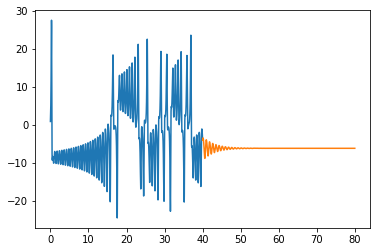

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

plt.plot(t, x[:, 1])
plt.plot(t2, x2[:, 1])

In [3]:
from grid import grid

start = 0
end = np.argmax(t_lorenz > 40)
grid.set_params(estimator__estimator__stridge2__fit_intercept=True)
grid.fit(x[start:end],
        dx[start:end])

model = grid.best_estimator_

In [4]:
from adaptive_sindy import make_targets, my_error


def original_targets():
    lorenz_x = {"x0": -10, "x1": 10, "offset": 0}
    lorenz_y = {"x0": 28, "x1": -1, "x0x2": -1, "offset": 0}
    lorenz_z = {"x0x1": 1, "x2": -8/3, "offset": 0}
    return make_targets(grid, [lorenz_x, lorenz_y, lorenz_z])


def updated_targets():
    lorenz_x = {"x0": -10, "x1": 10, "offset": 0}
    lorenz_y = {"x0": 15, "x1": -1, "x0x2": -1, "offset": 0}
    lorenz_z = {"x0x1": 1, "x2": -8/3, "offset": 0}
    return make_targets(grid, [lorenz_x, lorenz_y, lorenz_z])

/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.02731e-20): result may not be accurate.
  overwrite_a=True).T
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.28281e-20): result may not be accurate.
  overwrite_a=True).T
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.28281e-20): result may not be accurate.
  overwrite_a=True).T
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.02731e-20): result may not be accurate.
  overwrite_a=True).T
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-condi

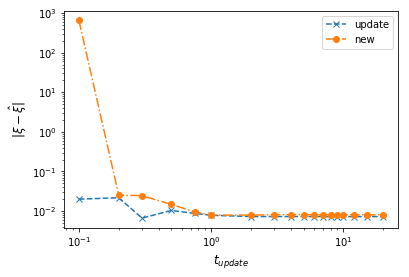

In [5]:
from sklearn.utils.validation import check_random_state
from copy import deepcopy
from sklearn.base import clone
from adaptive_sindy import refit, equation



def remodel_error(model, x, dx, t, t_start, t_up, sigma2, seed, error_func, targets, update=True):
    x = deepcopy(x)
    dx = deepcopy(dx)
    

    
    start = np.argmax(t > t_start)
    end = np.argmax(t > t_start + t_up)
    if sigma2 > 0:
        rng = check_random_state(seed)
        x += sigma2 * rng.normal(size=x.shape)
        dx += sigma2 * rng.normal(size=dx.shape)
    if update:
        updated_model = refit(model,
                              x[start:end+1],
                              dx[start:end+1])
    else:
        updated_model = model.fit(x[start:end+1], dx[start:end+1])
    return error_func(updated_model, targets)



t_start = 40
seed = 42
sigma2 = 0.000


t_update = np.array([0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20])
error_vs_time_update = [remodel_error(deepcopy(model), x_lorenz, dx_lorenz, t_lorenz, t_start, up,
                               sigma2, seed, my_error, updated_targets())
                        for up in t_update]


error_vs_time_new = [remodel_error(deepcopy(model), x_lorenz, dx_lorenz, t_lorenz, t_start, up,
                               sigma2, seed, my_error, updated_targets(), update=False)
                        for up in t_update]

import matplotlib as mpl

plt.loglog(t_update, error_vs_time_update, 'x--', label="update")
plt.loglog(t_update, error_vs_time_new, 'o-.', label="new")

plt.ylabel(r"$|\xi - \hat{\xi} |$", fontsize=12)
plt.xlabel(r"$t_{update}$",  fontsize=12)#
plt.legend()
#plt.savefig("../figures/noise/no_noise_comparison.pdf")

In [6]:
from joblib import Parallel, delayed
from grid import get_n_jobs
from cached import cached



def error_with_noise(model, sigmas, n_average, seed, x, dx, t, start, t_up, update=True):
    max_size = 2**32 - 1
    
    result = []
    
    rng = check_random_state(seed)
    
    with Parallel(n_jobs=get_n_jobs()) as parallel:
        for sigma in sigmas:

            errors = parallel(delayed(remodel_error)(deepcopy(model), x, dx, t, start, t_up,
                              sigma, rng.randint(0, max_size), my_error, updated_targets(), update=update)
                         for _ in range(n_average))
            result.append(errors)
      
    return result


start = 0
end = np.argmax(t_lorenz > 40)
alpha = grid.param_grid["estimator__stridge2__alpha"]
if 0 in alpha:
    alpha.pop(alpha.index(0))
    
grid.fit(x[start:end],
        dx[start:end])

model = grid.best_estimator_

sigmas = [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
n_average = 20
seed = 42
t_start = 40
t_up = [0.1, 0.5, 0.75, 1]

check = lambda x: (tuple(x) if isinstance(x, list) else x)
hsh = hash(tuple(map(check, [sigmas, n_average, t_start, t_up])))


#@cached("./cache/noise__{}.dill".format(hsh), overwrite=False)
def get_errors():
    errors = [error_with_noise(model, sigmas, n_average, seed,
                              x_lorenz, dx_lorenz, t_lorenz, t_start, tup)
              for tup in t_up]
    return np.array(errors)


errors = get_errors()

In [7]:
#@cached("./cache/noise-no-update__{}.dill".format(hsh), overwrite=False)
def get_errors():
    errors = [error_with_noise(model, sigmas, n_average, seed,
                              x_lorenz, dx_lorenz, t_lorenz, t_start, tup, update=False)
              for tup in t_up]
    return np.array(errors)


errors_no_update = get_errors()

/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parame

/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))
/Users/mq/.miniconda/envs/adaptive-sindy-oss/lib/python3.7/site-packages/sparsereg/model/base.py:114: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coeficients
  warnings.warn("Sparsity parameter is too big ({}) and eliminated all coeficients".format(self.threshold))


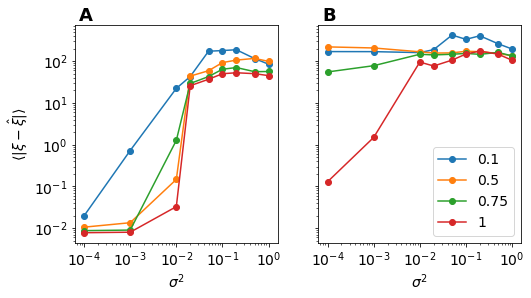

In [8]:
import string


with mpl.rc_context(rc={'font.size': 14}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2.), sharey=True)

    for error_no, error, tup in zip(errors_no_update, errors, t_up):
        ax1.loglog(sigmas, np.mean(error, axis=1), 'o-', label=tup)
        ax2.loglog(sigmas, np.mean(error_no, axis=1), 'o-', label=tup)

    ax1.set_ylabel(r"$\langle | \xi - \hat{\xi} | \rangle$")
    for i, ax in enumerate([ax1, ax2]):
        ax.set_xlabel(r"$\sigma^2$")
        ax.text(0.02, 1.02, s=string.ascii_uppercase[i], transform=ax.transAxes, weight='bold', fontsize=18)
    ax2.legend(loc="lower right")
    #plt.savefig("../figures/noise/sigma_vs_error.pdf")